In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import sagemaker
data_location='s3://sagemaker-us-west-2-886035371869/Capstone Project/Google_Stock_Price_Train.csv'
test_location='s3://sagemaker-us-west-2-886035371869/Capstone Project/Google_Stock_Price_Test.csv'
train_df=pd.read_csv(data_location)
test_df=pd.read_csv(test_location)

No handlers could be found for logger "sagemaker"


In [3]:
train_df['Date']=[date.replace('/','-') for date in train_df['Date']]

In [4]:
train_df.head()

,Date,Open,High,Low,Close,Volume
0,1-3-2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1-4-2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1-5-2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1-6-2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1-9-2012,322.04,322.29,309.46,620.76,"11,688,800"


In [5]:
test_df['Date']=[date.replace('/','-') for date in test_df['Date']]
test_df.head()

,Date,Open,High,Low,Close,Volume
0,1-3-2017,778.81,789.63,775.80,786.14,"1,657,300"
1,1-4-2017,788.36,791.34,783.16,786.90,"1,073,000"
2,1-5-2017,786.08,794.48,785.02,794.02,"1,335,200"
3,1-6-2017,795.26,807.90,792.20,806.15,"1,640,200"
4,1-9-2017,806.40,809.97,802.83,806.65,"1,272,400"


In [6]:
train_df.set_index(train_df['Date'],inplace=True)
train_df.drop(labels='Date',axis=1,inplace=True)
train_df.head()

,Open,High,Low,Close,Volume
Date,,,,,
1-3-2012,325.25,332.83,324.97,663.59,"7,380,500"
1-4-2012,331.27,333.87,329.08,666.45,"5,749,400"
1-5-2012,329.83,330.75,326.89,657.21,"6,590,300"
1-6-2012,328.34,328.77,323.68,648.24,"5,405,900"
1-9-2012,322.04,322.29,309.46,620.76,"11,688,800"


In [7]:
close_df=train_df['Close'].copy()
close_df.head()
#close_df.shape

Date
1-3-2012    663.59
1-4-2012    666.45
1-5-2012    657.21
1-6-2012    648.24
1-9-2012    620.76
Name: Close, dtype: object

In [8]:
close_df=[x.replace(',','') for x in close_df.values]
#print(close_df)

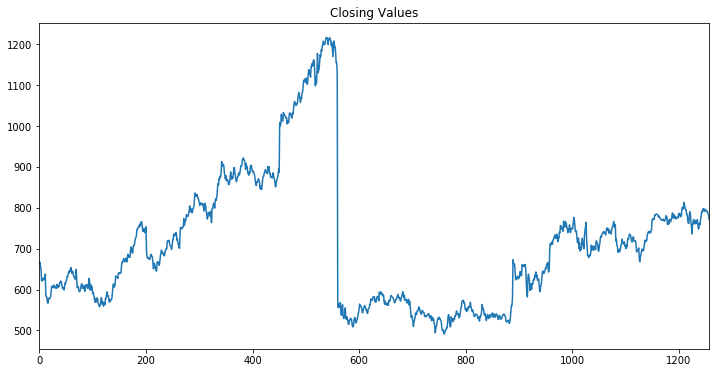

0    663.59
1    666.45
2    657.21
3    648.24
4    620.76
dtype: float64

In [9]:
plt.figure(figsize=(12,6))
closed_series=pd.Series(close_df)
closed_series=pd.to_numeric(closed_series)
closed_series.plot(title="Closing Values",x=train_df.index)
plt.show()
closed_series.head()

In [10]:
closed_series.index=train_df.index

In [11]:
closed_series.head()

Date
1-3-2012    663.59
1-4-2012    666.45
1-5-2012    657.21
1-6-2012    648.24
1-9-2012    620.76
dtype: float64

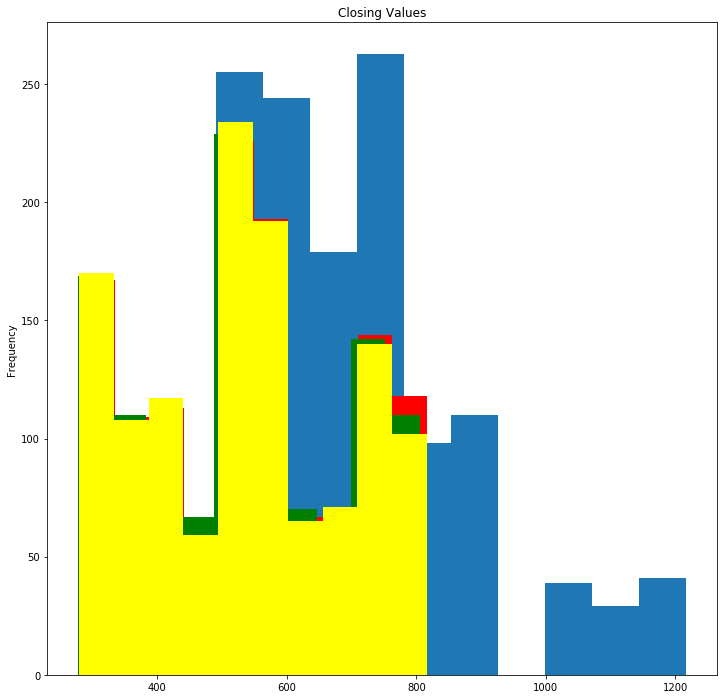

In [15]:
plt.figure(figsize=(12,12))
closed_series.plot(title="Closing Values",x=train_df.index,kind='hist')
train_df['High'].plot(color='red',kind='hist')
train_df['Low'].plot(color='green',kind='hist')
train_df['Open'].plot(color='yellow',kind='hist')

plt.show()

In [17]:
def make_time_series(df,years,freq='D',start_idx=0):
    time_series=[]
    leap='2012'
    for i in range(len(years)):
        
        year=years[i]

        if(year == leap):
            end_idx = start_idx+366
        else:
            end_idx = start_idx+365
        
        t_start=year+'-01-01'
        t_end=year+'-12-31'
        
        data=df[start_idx:end_idx].values
        
        index=pd.DatetimeIndex(start=t_start,end=t_end,freq=freq)
        time_series.append(pd.Series(data=data,index=index))
        start_idx=end_idx
    return time_series
    
    
    

In [55]:
print(train_df['High'][0:20].values)
x=[]
x.append([pd.Series(list(train_df['High'][0:20].values))])
x.append([pd.Series(list(train_df['Volume'][0:20].values))])
print(x)

[332.83 333.87 330.75 328.77 322.29 315.72 313.52 315.26 312.3  314.81
 315.82 319.3  294.4  293.23 292.74 288.27 286.17 289.08 288.92 290.91]
[[0     332.83
1     333.87
2     330.75
3     328.77
4     322.29
5     315.72
6     313.52
7     315.26
8     312.30
9     314.81
10    315.82
11    319.30
12    294.40
13    293.23
14    292.74
15    288.27
16    286.17
17    289.08
18    288.92
19    290.91
dtype: float64], [0      7,380,500
1      5,749,400
2      6,590,300
3      5,405,900
4     11,688,800
5      8,824,000
6      4,817,800
7      3,764,400
8      4,631,800
9      3,832,800
10     5,544,000
11    12,657,800
12    21,231,800
13     6,851,300
14     6,134,400
15    10,012,700
16     6,476,500
17     7,262,000
18     4,678,400
19     4,300,700
dtype: object]]


# Making dynamic features

In [105]:
def make_dynamic_features(df,years,freq='D',start_index=0):
    
    dynamic_features=[]
    leap='2012'
    
    for i in range(len(years)):
        
        year=years[i]
        if (year==leap):
            end_index=start_index+366
        else:
            end_index=start_index+365
            
        volume_df=df['Volume'].copy()
        volume_df=[x.replace(',','') for x in volume_df.values]

            
#        data=pd.Series(list(df['High'][start_index:end_index].values))
#        data2=(list(df['Volume'][start_index:end_index].values))
        data2=(list(volume_df))

        data2=list(map(int,data2)) # => [1,2,3]

#        dynamic_features.append([pd.concat([data,data2],axis=1)])
        dynamic_features.append((data2))
#        dynamic_features.append([pd.Series(data2)])
        start_index=end_index
        
    return dynamic_features

In [18]:
t_start='2012-01-01'
t_end='2012-12-31'
freq='D'
index=pd.DatetimeIndex(start=t_start,end=t_end,freq=freq)
print(len(index))

data=closed_series[0:366].values
print(len(data))

366
366


/home/ec2-user/anaconda3/envs/amazonei_mxnet_p27/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.


In [19]:
years=['2012','2013','2014']
freq='D'

time_series=make_time_series(closed_series,years,freq)

/home/ec2-user/anaconda3/envs/amazonei_mxnet_p27/lib/python2.7/site-packages/ipykernel/__main__.py:18: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.


* Making Dynamic Features

In [106]:
years=['2012','2013','2014']
freq='D'
dynamic_features=make_dynamic_features(train_df,years,freq)

In [120]:
print(len(dynamic_features))
#dynamic_features
#time_series

3


* Function to create training time series

In [21]:
def create_training_series(complete_time_series,prediction_length):
    
    time_series_training=[]
    
    for ts in complete_time_series:
        time_series_training.append(ts[:-prediction_length])
        
    return time_series_training

In [110]:
def create_training_dynamic_features(df,years,prediction_length,start_index=0):
    
    training_dynamic_features=[]
    leap='2012'
    
    for i in range(len(years)):
        
        year=years[i]
        if (year==leap):
            end_index=(start_index+366)-prediction_length
        else:
            end_index=(start_index+365)-prediction_length
            
        volume_df=df['Volume'].copy()
        volume_df=[x.replace(',','') for x in volume_df.values]
        volume_df=volume_df[start_index:end_index]
        data2=(list(volume_df))

        data2=list(map(int,data2)) # => [1,2,3]        
            
#        data=pd.Series(list(df['High'][start_index:end_index].values))
#        data2=pd.Series(list(df['Volume'][start_index:end_index].values))
#        training_dynamic_features.append([pd.concat([data,data2],axis=1)])
        training_dynamic_features.append((data2))
        
#        dynamic_features.append([pd.Series(data2)])
        start_index=end_index
        
    return training_dynamic_features

In [22]:
prediction_length=30
time_series_training=create_training_series(time_series,prediction_length)

* Making training dynamic features

In [111]:
prediction_length=30
dynamic_features_training=create_training_dynamic_features(train_df,years,prediction_length)

* Plotting training and test series

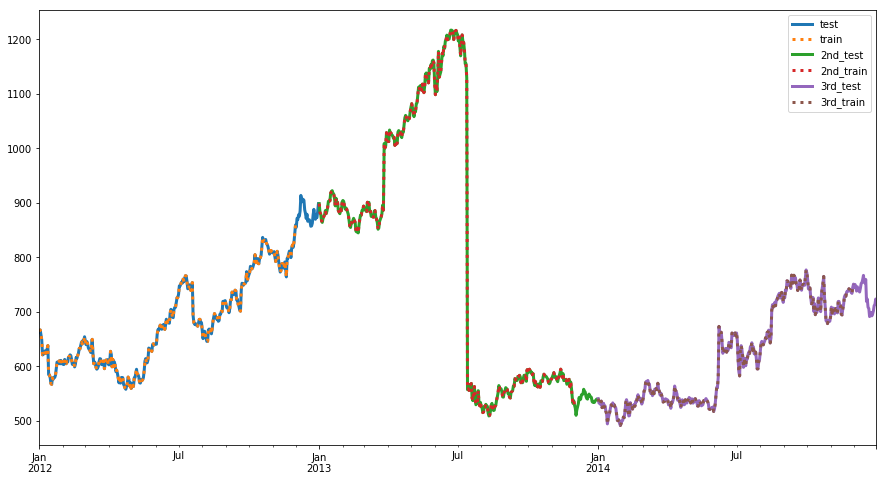

In [23]:
# display train/test time series
time_series_idx = 0

plt.figure(figsize=(15,8))
# test data is the whole time series
time_series[time_series_idx].plot(label='test', lw=3)
# train data is all but the last prediction pts
time_series_training[time_series_idx].plot(label='train', ls=':', lw=3)

# for 2nd time series

time_series[1].plot(label='2nd_test',lw=3)
time_series_training[1].plot(label='2nd_train',ls=':',lw=3)


time_series[2].plot(label='3rd_test',lw=3)
time_series_training[2].plot(label='3rd_train',ls=':',lw=3)



plt.legend()
plt.show()

In [24]:
# We have to save the darta first locallt to upload it to s3
import os
data_dir='Capstone_Project_data'

if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [25]:
# function to convert a line to json format

def series_to_json(ts):
    
    json_obj={'start':str(ts.index[0]),'target':list(ts)}
    
    return json_obj

In [95]:
# This is to further include dynamic features

def series_to_json_with_dynamic_feat(ts,complete_dynamic_features):
    json_obj={'start':str(ts.index[0]),'target':list(ts),'dynamic_feat':list(complete_dynamic_features)}
    
    return json_obj

In [121]:
# Now running this

def series_to_json_with_dynamic_feat(ts,complete_dynamic_features):
    json_obj={'start':str(ts.index[0]),'target':list(ts),'dynamic_feat':complete_dynamic_features}
    
    return json_obj

In [27]:
# The function to convert dict to json and saving it locally
import json
def write_json_dataset(time_series,filename):
    
    with open(filename,'wb') as f:
        
        for ts in time_series:
            json_line=json.dumps(series_to_json(ts))+'\n'
            json_line=json_line.encode('utf-8')
            f.write(json_line)
    print(filename+' saved')

In [122]:
# To save locally the json file with dynamic features
def write_json_dataset_dynamic_features(time_series,complete_dynamic_features,filename):
    
    with open(filename,'wb') as f:
        
        for ts in time_series:
            json_line=json.dumps(series_to_json_with_dynamic_feat(ts,complete_dynamic_features))+'\n'
            json_line=json_line.encode('utf-8')
            f.write(json_line)
    print(filename+' saved')

In [124]:
# Directories to save train and test data

train_dynamic_key=os.path.join(data_dir,'train_dynamic.json')
test_dynamic_key=os.path.join(data_dir,'test_dynamic.json')

write_json_dataset_dynamic_features(time_series_training,dynamic_features_training,train_dynamic_key)
# time_series_test is actually complete time series
time_series_test=time_series
write_json_dataset_dynamic_features(time_series_test,dynamic_features,test_dynamic_key)

Capstone_Project_data/train_dynamic.json saved
Capstone_Project_data/test_dynamic.json saved


# Sagemaker Resources

In [113]:
import sagemaker
from sagemaker import get_execution_role
import boto3

sagemaker_session=sagemaker.Session()
role=get_execution_role()
bucket=sagemaker_session.default_bucket()

* Uploading train and test json files to s3

In [125]:
prefix='Udacity-Capstone-Stock-Prices'

import os
train_key=os.path.join(data_dir,'train.json')
test_key=os.path.join(data_dir,'test.json')

# for uploading dynamic features also
train_dynamic_key=os.path.join(data_dir,'train_dynamic.json')
test_dynamic_key=os.path.join(data_dir,'test_dynamic.json')

train_prefix='{}/{}'.format(prefix,'train')
test_prefix='{}/{}'.format(prefix,'test')

'''
train_path=sagemaker_session.upload_data(train_key,bucket=bucket,key_prefix=train_prefix)
test_path=sagemaker_session.upload_data(test_key,bucket=bucket,key_prefix=test_prefix)
'''

train_dynamic_path=sagemaker_session.upload_data(train_dynamic_key,bucket=bucket,key_prefix=train_prefix)
test_dynamic_path=sagemaker_session.upload_data(test_dynamic_key,bucket=bucket,key_prefix=test_prefix)

* Importing the Image

In [115]:
from sagemaker.amazon.amazon_estimator import get_image_uri
image_name=get_image_uri(boto3.Session().region_name,
                        'forecasting-deepar')

* Defining the estimator

In [57]:

output_path='s3://{}/{}/output'.format(bucket,prefix)

from sagemaker.estimator import Estimator
estimator2=Estimator(sagemaker_session=sagemaker_session,
                   image_name=image_name,
                   role=role,
                   train_instance_count=1,
                   train_instance_type='ml.c4.xlarge',
                   output_path=output_path)

# Estimator for training on data with dynamic features

In [116]:

output_path='s3://{}/{}/output_dynamic'.format(bucket,prefix)

from sagemaker.estimator import Estimator
estimator_dynamaic=Estimator(sagemaker_session=sagemaker_session,
                   image_name=image_name,
                   role=role,
                   train_instance_count=1,
                   train_instance_type='ml.c4.xlarge',
                   output_path=output_path)

* Setting hyperparameters

In [117]:
context_length=30
prediction_length=context_length
freq='D'
hyperparameters={
    'epochs':'50',
    'time_freq':freq,
    'prediction_length':str(prediction_length),
    'context_length':str(context_length),
    'num_cells':'50',
    'num_layers':'2',
    'learning_rate':'0.001',
    'early_stopping_patience':'10',
    'mini_batch_size':'32'
}

estimator_dynamaic.set_hyperparameters(**hyperparameters)

* Defing train and test paths, on which training job would be performed

In [126]:
data_channels={
    'train':train_dynamic_path,
    'test':test_dynamic_path
}
estimator_dynamaic.fit(inputs=data_channels)

2020-09-01 14:55:14 Starting - Starting the training job...
2020-09-01 14:55:16 Starting - Launching requested ML instances......
2020-09-01 14:56:41 Starting - Preparing the instances for training......
2020-09-01 14:57:33 Downloading - Downloading input data...
2020-09-01 14:58:04 Training - Downloading the training image..Arguments: train
[09/01/2020 14:58:27 INFO 139670841915200] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u'auto', u'likelihood': u'student-t', u'early_stopping_patience': u''}
[09/01/2020 14:58:2

UnexpectedStatusException: Error for Training job forecasting-deepar-2020-09-01-14-55-14-632: Failed. Reason: ClientError: Error "setting an array element with a sequence." occurred, when reading field "dynamic_feat" (source: /opt/ml/input/data/train/train_dynamic.json, row: 1)

# Deploying the model in the usual way


In [62]:
%%time

# create a predictor
predictor2 = estimator2.deploy(endpoint_name='usual-way-made-endpoint',
    initial_instance_count=1,
    instance_type='ml.t2.medium',
    content_type="application/json" # specify that it will accept/produce JSON
)

---------------!CPU times: user 281 ms, sys: 13.3 ms, total: 294 ms
Wall time: 7min 32s


In [10]:
# Now I am trying to deploy the model by specifying the job name and location of model artifacts
import sagemaker
training_job_name='forecasting-deepar-2020-08-31-19-17-07-165'

model_name = training_job_name + '-mod'

import boto3
boto3_sm = boto3.client('sagemaker')


info = boto3_sm.describe_training_job(TrainingJobName=training_job_name)
#info = sagemaker.describe_training_job(TrainingJobName=training_job_name)
model_data = info['ModelArtifacts']['S3ModelArtifacts']
print(model_data)

from sagemaker.amazon.amazon_estimator import get_image_uri

container=get_image_uri(boto3.Session().region_name,
                        'forecasting-deepar')

primary_container = {
    'Image': container,
    'ModelDataUrl': model_data
}

create_model_response = boto3_sm.create_model(
    ModelName = model_name,
    ExecutionRoleArn = role,
    PrimaryContainer = primary_container)

print(create_model_response['ModelArn'])

s3://sagemaker-us-west-2-886035371869/Udacity-Capstone-Stock-Prices/output/forecasting-deepar-2020-08-31-19-17-07-165/output/model.tar.gz
arn:aws:sagemaker:us-west-2:886035371869:model/forecasting-deepar-2020-08-31-19-17-07-165-mod



# I created the endpoint manually ,from the model, that i created from the previous cell:
  endpoint name is:Capstone-Project-manually-made-endpoint

In [30]:
# Invoking already existing endpoint, and having a predictor

endpoint_name='Capstone-Project-manually-made-endpoint'
predictor=sagemaker.predictor.RealTimePredictor(endpoint=endpoint_name)

In [31]:
from sagemaker.predictor import csv_serializer,json_deserializer,json_serializer
predictor.content_type='application/json'
predictor.serializer=json_serializer
predictor.deserializer=json_deserializer

# JSON Prediction Request

In [44]:
def json_predictor_input(input_ts, num_samples=20, quantiles=['0.1', '0.5', '0.9']):
    '''Accepts a list of input time series and produces a formatted input.
       :input_ts: An list of input time series.
       :num_samples: Number of samples to calculate metrics with.
       :quantiles: A list of quantiles to return in the predicted output.
       :return: The JSON-formatted input.
       '''
    # request data is made of JSON objects (instances)
    # and an output configuration that details the type of data/quantiles we want
    
    instances = []
    for k in range(len(input_ts)):
        # get JSON objects for input time series
        instances.append(series_to_json(input_ts[k]))

    # specify the output quantiles and samples
    configuration = {"num_samples": num_samples, 
                     "output_types": ["quantiles"], 
                     "quantiles": quantiles}

    request_data = {"instances": instances, 
                    "configuration": configuration}

    json_request = json.dumps(request_data).decode()
    
    return json_request

In [63]:
# get all input and target (test) time series
input_ts = time_series_training
target_ts = time_series

# get formatted input time series
json_input_ts = json_predictor_input(input_ts)

# get the prediction from the predictor


In [38]:
print((json_input_ts.index))

<built-in method index of str object at 0x562787892f50>


In [64]:
json_prediction = predictor2.predict(json_input_ts)

In [65]:
# helper function to decode JSON prediction
def decode_prediction(prediction, encoding='utf-8'):
    '''Accepts a JSON prediction and returns a list of prediction data.
    '''
    prediction_data = json.loads(prediction.decode(encoding))
    prediction_list = []
    for k in range(len(prediction_data['predictions'])):
        prediction_list.append(pd.DataFrame(data=prediction_data['predictions'][k]['quantiles']))
    return prediction_list


prediction_list = decode_prediction(json_prediction)

# should get a list of 30 predictions 
# with corresponding quantile values
print(prediction_list[0])

           0.1         0.5         0.9
0   821.657776  847.944946  858.382996
1   838.563293  854.589478  870.448120
2   842.322205  859.460144  879.949829
3   848.151917  859.029663  892.957642
4   834.631470  861.670105  879.262512
5   854.743774  868.009216  905.846924
6   845.816467  870.404175  889.706787
7   846.286194  876.849670  912.037781
8   848.551331  871.522949  902.303589
9   856.970520  878.489685  904.616028
10  844.404419  883.487671  914.426331
11  847.022400  890.563843  922.885498
12  842.444580  879.885437  920.196533
13  849.233521  886.186707  905.786499
14  844.957825  897.515747  921.986633
15  858.932678  887.929565  915.009338
16  831.793579  893.727112  914.195557
17  863.059265  899.472412  926.899170
18  858.560974  889.624268  923.083679
19  855.798218  902.746277  917.317749
20  856.935120  905.865967  936.330811
21  872.789917  902.765137  940.296997
22  870.137878  909.700317  953.643555
23  884.016418  903.530273  931.958435
24  869.838989  917.18597

In [66]:
# display the prediction median against the actual data
def display_quantiles(prediction_list, target_ts=None):
    # show predictions for all input ts
    for k in range(len(prediction_list)):
        plt.figure(figsize=(12,6))
        # get the target month of data
        if target_ts is not None:
            target = target_ts[k][-prediction_length:]
            plt.plot(range(len(target)), target, label='target')
        # get the quantile values at 10 and 90%
        p10 = prediction_list[k]['0.1']
        p90 = prediction_list[k]['0.9']
        # fill the 80% confidence interval
        plt.fill_between(p10.index, p10, p90, color='y', alpha=0.5, label='80% confidence interval')
        # plot the median prediction line
        prediction_list[k]['0.5'].plot(label='prediction median')
        plt.legend()
        plt.show()

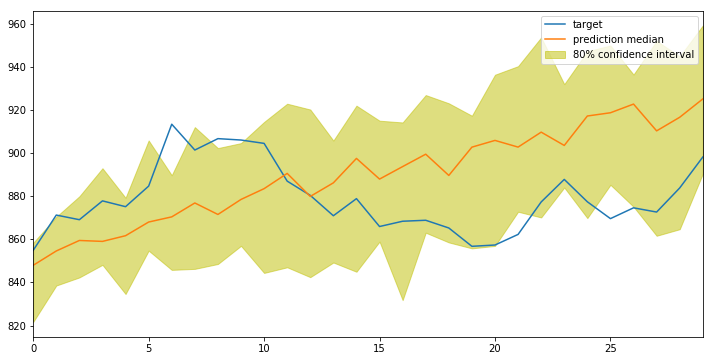

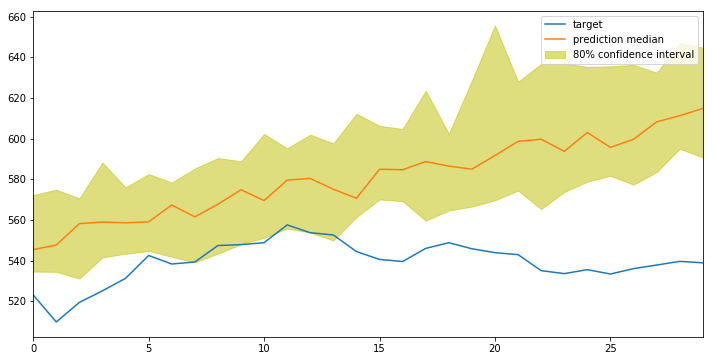

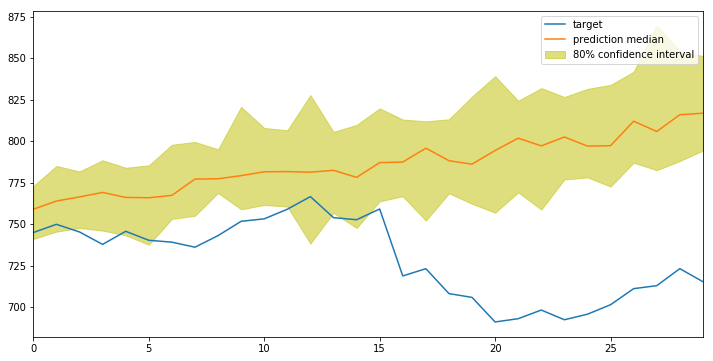

In [67]:
display_quantiles(prediction_list, target_ts)